In [13]:
import os
import numpy as np
import plotly.graph_objects as go

import gzip
import pickle as pkl

def loadall_results2(path, n_folds):
    regret = []
    history_actions = []
    history_outcomes = []
    perf = []
    with gzip.open(  path ,'rb') as f:
        for i in range(n_folds+1):
            try:
                data = pkl.load(f)
            except EOFError:
                break

            if type(data) == dict:
                regret.append( data['regret'] ) 
                history_actions.append( data['action_history'] )
                history_outcomes.append( data['outcome_history'] ) 
                perf.append( data['pred'] ) 

    
    return regret, history_actions, history_outcomes, perf

In [19]:
n_folds = 1
horizon = 9999
context = 'MNISTbinary'
model = 'MLP'
case = 'case1'
agent_name = 'EEneuralcbpside_v6' #ineural6, neuronal6

direct = './results/'
path = os.path.join(direct, '{}_{}_{}_{}_{}_{}.pkl.gz'.format(case,model,context,horizon,n_folds,agent_name) )
regret, action_history,outcome_history, perf = loadall_results2(path, n_folds)


In [1]:
regret

NameError: name 'regret' is not defined

In [36]:
n_folds = 25
horizon = 9999
context = 'MNISTbinary'
model = 'MLP'
agent_name = 'EEneuralcbpside_v6'

case = 'case1'
direct = './results/'
path = os.path.join(direct, '{}_{}_{}_{}_{}_{}.pkl.gz'.format(case,model,context,horizon,n_folds,agent_name) )
r1, h1 = loadall_results2(path, n_folds)


case = 'case1b'
direct = './results/'
path = os.path.join(direct, '{}_{}_{}_{}_{}_{}.pkl.gz'.format(case,model,context,horizon,n_folds,agent_name) )
r2, h2 = loadall_results2(path, n_folds)


In [147]:
from collections import Counter
import pandas as pd
import numpy as np

final_df = pd.DataFrame()
final_fp_action1 = {}
final_fp_action2 = {}

for d, case in zip([h1, h2],['case1', 'case2']):
    # Assuming h1 is defined earlier in your code
    h = [np.array(i) for i in d]

    exploitation_df = pd.DataFrame()
    exploration_df = pd.DataFrame()
    total_df = pd.DataFrame()


    fp_rates_action1 = []
    fp_rates_action2 = []
    for i in range(len(h)):

        counts_total = Counter(h[i][:, 0])
        temp_total_df = pd.DataFrame(counts_total.items(), columns=['Action', 'Count'])
        temp_total_df['seed'] = i
        total_df = pd.concat([total_df, temp_total_df], ignore_index=True)
        
        # Counting the occurrences for 'exploited'
        exploited = np.array([j for j in h[i] if j[0] != 0])
        counts_exploited = Counter(exploited[:, 0])
        temp_exploitation_df = pd.DataFrame(counts_exploited.items(), columns=['Action', 'Count'])
        temp_exploitation_df['seed'] = i
        exploitation_df = pd.concat([exploitation_df, temp_exploitation_df], ignore_index=True)

        # Counting the occurrences for 'explored'
        explored = np.array([j for j in h[i] if j[0] == 0])
        counts_explored = Counter(explored[:, 1])
        temp_exploration_df = pd.DataFrame(counts_explored.items(), columns=['Outcome', 'Count'])
        temp_exploration_df['seed'] = i
        exploration_df = pd.concat([exploration_df, temp_exploration_df], ignore_index=True)

        fp_rates_action1.append( sum ( [ 1 for i in h[i] if i[0]==1 and i[1]==1 ] ) / sum ( [ 1 for i in h[i] if i[0]==1  ] ) )
        fp_rates_action2.append( sum ( [ 1 for i in h[i] if i[0]==2 and i[1]==0 ] ) / sum ( [ 1 for i in h[i] if i[0]==2  ] ) )

    count_df = total_df.groupby('Action')['Count'].mean().reset_index()
    count_df.columns = ['Action', 'Mean Count']
    count_df['Std'] = total_df.groupby('Action')['Count'].std()
    count_df['Game'] = case

    final_fp_action1[case] = fp_rates_action1
    final_fp_action2[case] = fp_rates_action2


    final_df = pd.concat([final_df, count_df], ignore_index=True)

final_df['Action'] = final_df['Action'].astype('string')

In [150]:
print(np.mean(final_fp_action1['case1']),np.std(final_fp_action1['case1']),np.mean(final_fp_action1['case2']),np.std(final_fp_action1['case2']) ) 
print(np.mean(final_fp_action2['case1']),np.std(final_fp_action2['case1']),np.mean(final_fp_action2['case2']),np.std(final_fp_action2['case2']) ) 

0.07411002549244135 0.014952313360779318 0.03498382775645754 0.006651784841780269
0.06556348851403537 0.016060412009564762 0.10280906151351452 0.02201940884478099


In [132]:
import plotly.express as px

fig = px.bar(final_df, x="Action", y="Mean Count", color="Game")

# Set the figure size (width, height in pixels)
# fig.update_layout(width=800, height=600, barmode='group')

# Reduce the width of the bars
fig.update_traces(marker=dict(line=dict(width=0.5)))

# fig.show()

siz = 12.5
fig.update_layout(
    width=220,
    height=220,
    plot_bgcolor='white',  # Sets the plot background color
    paper_bgcolor='white',  # Sets the overall figure background color
    barmode='group',
    margin=dict(l=20, r=1, t=1, b=20),  # Small margins

    xaxis=dict(
        tickmode='array',
        title_standoff=5,
        title_font=dict(size=siz-2),
        tickfont=dict(size=siz-2)  # Increase X-axis tick font size
    ),
    yaxis=dict(
        gridcolor='lightgrey',
        title="Count",
        title_standoff=5,
        title_font=dict(size=siz-2),
        tickfont=dict(size=siz-2)  # Increase Y-axis tick font size
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.33,  # Adjust this value to position the legend
        xanchor="center",
        x=0.5,
        font=dict(size=siz)  # Increase legend font size
    ),
)

fig.show()
fig.write_image("./cost-sensitive.pdf" )

In [434]:
n_folds = 25
horizon = 9999
context = 'adult'
model = 'MLP'
case = 'case1'

material = {
    #'EEneuralcbpside_v5': {'color': [255, 255, 0], 'label': 'EEneuralcbpside_v5'},  # Red
    'EEneuralcbpside_v6': {'color': [255, 0, 0], 'label': 'EEneuralcbpside_v6'},  # Red
    'ineural6': {'color': [51, 255, 255], 'label':'IneurAL6'},                    # Yellow
    'ineural3': {'color': [0, 0, 255], 'label':'IneurAL3'},                    # Cyan
    'neuronal6': {'color': [255, 0, 255], 'label':'neuronal6'},                  # Magenta
    'neuronal3': {'color': [160, 160, 160], 'label':'neuronal3'},                   # Orange
    'margin': {'color': [160, 160, 160], 'label':'margin'},
    'cesa': {'color': [0, 0, 255], 'label':'cesa'},
}

#  'random':{'color':[204,0,204],'label':'e-greedy'}

fig = go.Figure( )

final_regrets = {}

for agent_name in material.keys():

    color, l_label = material[agent_name]['color'], material[agent_name]['label']
    # print(agent_name)

    r,g,b = color

    try:
        direct = './results/'

        path = os.path.join(direct, '{}_{}_{}_{}_{}_{}.pkl.gz'.format(case,model,context,horizon,n_folds,agent_name) )
        print(path)
        result = loadall_results2(path, n_folds)
        result = result[1:]
        result = result.astype(np.float32)
        print(result.shape)
    except:
        result = np.zeros((n_folds,horizon))


    final_regrets[l_label] = result[:,-1] 
    
    regret =  np.mean(result,0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std( result , 0 )
    upper_regret = regret + std


    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b),  dash=  'solid' ), mode='lines',  name=l_label,  showlegend=True )) # 
    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({}, {}, {},0.2)'.format(r,g,b), 
                            line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )   )


    
fig.update_layout(autosize=False,
                  xaxis_title="Sequence", yaxis_title="Regret and Standard Dev.",  
                  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   
                  font=dict(size=20,),
                  legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.1) )

# fig.update_yaxes( type="log" )
# fig.update_xaxes( type="log" )

# fig.update_layout( yaxis=dict(range=[0, 2000] ) )

fig.show()
# fig.write_image("./figures/case1_{}_{}.pdf".format(model, context) )

./results/case1_MLP_adult_9999_25_EEneuralcbpside_v6.pkl.gz
(25, 9999)
./results/case1_MLP_adult_9999_25_ineural6.pkl.gz
(25, 9999)
./results/case1_MLP_adult_9999_25_ineural3.pkl.gz
(25, 9999)
./results/case1_MLP_adult_9999_25_neuronal6.pkl.gz
(25, 9999)
./results/case1_MLP_adult_9999_25_neuronal3.pkl.gz
(25, 9999)
./results/case1_MLP_adult_9999_25_margin.pkl.gz
(25, 9999)
./results/case1_MLP_adult_9999_25_cesa.pkl.gz
(25, 9999)


In [6]:
n_folds = 25
horizon = 9999
model = 'MLP'


material = {
    #'EEneuralcbpside_v5': {'color': [255, 255, 0], 'label': 'EEneuralcbpside_v5'},  # Red
    'EEneuralcbpside_v6': {'color': [255, 0, 0], 'label': 'Neural-CBP'},  # Red
    'ineural6': {'color': [51, 255, 255], 'label':'IneurAL (official)'},                    # Yellow
    'ineural3': {'color': [0, 0, 255], 'label':'IneurAL (tuned)'},                    # Cyan
    'neuronal6': {'color': [255, 0, 255], 'label':'Neuronal (official)'},                  # Magenta
    'neuronal3': {'color': [160, 160, 160], 'label':'Neuronal (tuned)'},                   # Orange
    'margin': {'color': [160, 160, 160], 'label':'Margin'},
    'cesa': {'color': [0, 0, 255], 'label':'Cesa'},
}

#  'random':{'color':[204,0,204],'label':'e-greedy'}

fig = go.Figure( )



data_models = {}
for model in ['MLP', 'LeNet']: 

    if model == 'MLP':
        n_folds = 25
        datasets = ['MNISTbinary', 'MagicTelescope', 'adult',  'MNIST', 'FASHION', 'covertype', 'shuttle',]
    else:
        datasets = ['MNIST', 'FASHION', 'CIFAR10',]
        n_folds = 25

    data_regrets = {} 
    for data in datasets: 

        if data in ['MNIST', 'FASHION', 'CIFAR10']:
            case = 'case2' 
        elif data in ['covertype', 'shuttle']:
            case = 'game_case_seven'
        else:
            case = 'case1'
            
        final_regrets = {}
        for agent_name in material.keys():

            color, l_label = material[agent_name]['color'], material[agent_name]['label']

            r,g,b = color

            try:
                direct = './results/'
                path = os.path.join(direct, '{}_{}_{}_{}_{}_{}.pkl.gz'.format(case, model, data, horizon,n_folds,agent_name) )
                print(path)
                result = loadall_results2(path, n_folds)
                result = result[1:]
                result = result.astype(np.float32)
                print(result.shape)
                final_regrets[l_label] = result[:,-1] 
            except:
                result = np.zeros((n_folds,horizon))

        if data == 'MNISTbinary':
            data = 'MNIST binary'
        if data == 'FASHION':
            data = 'Fashion'
            
        data_regrets[data] = final_regrets
        
    data_models[model] = data_regrets


# fig.show()
# fig.write_image("./figures/case1_{}_{}.pdf".format(model, context) )

./results/case1_MLP_MNISTbinary_9999_25_EEneuralcbpside_v6.pkl.gz
(25, 9999)
./results/case1_MLP_MNISTbinary_9999_25_ineural6.pkl.gz
(25, 9999)
./results/case1_MLP_MNISTbinary_9999_25_ineural3.pkl.gz
(25, 9999)
./results/case1_MLP_MNISTbinary_9999_25_neuronal6.pkl.gz
(25, 9999)
./results/case1_MLP_MNISTbinary_9999_25_neuronal3.pkl.gz
(25, 9999)
./results/case1_MLP_MNISTbinary_9999_25_margin.pkl.gz
(25, 9999)
./results/case1_MLP_MNISTbinary_9999_25_cesa.pkl.gz
(25, 9999)
./results/case1_MLP_MagicTelescope_9999_25_EEneuralcbpside_v6.pkl.gz
(25, 9999)
./results/case1_MLP_MagicTelescope_9999_25_ineural6.pkl.gz
(25, 9999)
./results/case1_MLP_MagicTelescope_9999_25_ineural3.pkl.gz
(25, 9999)
./results/case1_MLP_MagicTelescope_9999_25_neuronal6.pkl.gz
(25, 9999)
./results/case1_MLP_MagicTelescope_9999_25_neuronal3.pkl.gz
(25, 9999)
./results/case1_MLP_MagicTelescope_9999_25_margin.pkl.gz
(25, 9999)
./results/case1_MLP_MagicTelescope_9999_25_cesa.pkl.gz
(25, 9999)
./results/case1_MLP_adult_999

In [7]:
import pandas as pd
# pd.DataFrame(data_regrets)
# data_regrets

samples = []

# Iterate over the dictionary to extract data
for model, dataset in data_models.items():
    for data, approach in dataset.items():
        for appr, values in approach.items():
            for val in values:
                samples.append([model, data, appr, val])

# Create a DataFrame
df = pd.DataFrame(samples, columns=['Model','Dataset', 'Approach', 'Value'])


# Calculate mean and standard error for each group
grouped = df.groupby(['Model', 'Dataset', 'Approach'])
mean = grouped['Value'].mean().reset_index()
std_error = grouped['Value'].std() / np.sqrt(grouped['Value'].count())
std_error = std_error.reset_index()

# Merge the mean and standard error into a single DataFrame
result = pd.merge(mean, std_error, on=['Model', 'Dataset', 'Approach'])
result.rename(columns={'Value_x': 'Mean', 'Value_y': 'StdError'}, inplace=True)

result['merge'] = result['Model'] + result['Approach']
result['merge2'] = result['Model'] + result['Dataset']

In [9]:
result['merge'].unique()

array(['LeNetNeural-CBP', 'LeNetNeuronal (official)',
       'LeNetNeuronal (tuned)', 'MLPIneurAL (official)',
       'MLPIneurAL (tuned)', 'MLPNeural-CBP', 'MLPNeuronal (official)',
       'MLPNeuronal (tuned)', 'MLPCesa', 'MLPMargin'], dtype=object)

In [10]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
# Assuming df is your DataFrame and it has columns 'Dataset', 'Value', 'Model'

w = 0.1
def remove_substrings(s, substrings):
    for substring in substrings:
        s = s.replace(substring, '')
    return s


# approaches = result['merge'].unique()
approaches = np.array(['LeNetNeural-CBP', 'LeNetNeuronal (official)', 'LeNetNeuronal (tuned)',
                        'MLPNeural-CBP', 'MLPNeuronal (official)','MLPNeuronal (tuned)', 'MLPIneurAL (official)', 
                        'MLPIneurAL (tuned)',  'MLPCesa', 'MLPMargin' ], dtype=object) 
approaches_names = [ remove_substrings(model, ['LeNet', 'MLP']) for model in approaches ]
default_colors = px.colors.qualitative.Plotly
model_colors = {model_n:col for model_n,col in zip(approaches_names,default_colors) }


# Create an empty figure
fig = go.Figure()


views = []
for appr, appr_name in zip(approaches,approaches_names):

    subset = result[result['merge'] == appr]
    dec = False
    if appr_name not in views:
        dec = True
        views.append(appr_name)
    

    if 'CBP' in appr_name:
        fig.add_trace(go.Bar(
            x=subset['merge2'],
            y=subset['Mean'],
            name=appr_name,
            error_y=dict(type='data', array=subset['StdError'], visible=True,thickness=1 ),
            marker_color=model_colors[appr_name],marker_pattern_shape='x',marker_pattern_fgcolor='black', 
            showlegend = dec,
            # width=w
            ))
    else: 
        fig.add_trace(go.Bar(
            x=subset['merge2'],
            y=subset['Mean'],
            name=appr_name,
            error_y=dict(type='data', array=subset['StdError'], visible=True,thickness=1 ),
            marker_color=model_colors[appr_name], 
            showlegend = dec,
            # width=w
            ))


# Add vertical black lines between data groups

datasets = result['merge2'].unique()
print(datasets)
for i, dataset in enumerate(datasets[:-1]):
    if i == 2:
        fig.add_vline(x=i + 0.5, line_width=2, line_color="black")
    else:
        fig.add_vline(x=i + 0.5, line_width=2, line_color="black",  line_dash="dot")


siz = 13

fig.add_shape(
    type="line", xref="paper", yref="paper",
    x0=0.31,
    y0=1.01,
    x1=0.99,
    y1=1.01,
    line_width=2,
    label=dict(text="MLP", font=dict(size=siz+2)),
)


fig.add_shape(
    type="line", xref="paper", yref="paper",
    x0=0.31,
    y0=1.0125,
    x1=0.31,
    y1=0.95,
    line_width=2,
)


fig.add_shape(
    type="line", xref="paper", yref="paper",
    x0=0.99,
    y0=1.0125,
    x1=0.99,
    y1=0.95,
    line_width=2,
)



fig.add_shape(
    type="line", xref="paper", yref="paper",
    x0=0.01,
    y0=1.01,
    x1=0.29,
    y1=1.01,
    line_width=2,
    label=dict(text="LeNet", font=dict(size=siz+2)),
)


fig.add_shape(
    type="line", xref="paper", yref="paper",
    x0=0.01,
    y0=1.0125,
    x1=0.01,
    y1=0.95,
    line_width=2,
)

fig.add_shape(
    type="line", xref="paper", yref="paper",
    x0=0.29,
    y0=1.0125,
    x1=0.29,
    y1=0.95,
    line_width=2,
)

# fig.update_traces(width=0.05)

# fig.update_traces(
#     marker_pattern_shape='/',  # This sets a grid-like pattern. Use '+' for a cross pattern.
#     marker_pattern_fgcolor='black',  # Foreground color of the pattern
#     marker_pattern_bgcolor='rgba(0,0,0,0)'  # Transparent background color for the pattern
# )

fig.update_layout(
    width=1000,
    height=220,
    plot_bgcolor='white',  # Sets the plot background color
    paper_bgcolor='white',  # Sets the overall figure background color
    barmode='group',
    margin=dict(l=20, r=1, t=25, b=20),  # Small margins
    xaxis=dict(
        tickmode='array',
        tickvals=result['merge2'].unique(),
        ticktext = [ remove_substrings(model, ['LeNet', 'MLP']) for model in result['merge2'].unique() ],
        tickfont=dict(size=siz-2)  # Increase X-axis tick font size
    ),
    yaxis=dict(
        gridcolor='lightgrey',
        title="Final regret ± standard dev.",
        title_standoff=10,
        title_font=dict(size=siz),
        tickfont=dict(size=siz)  # Increase Y-axis tick font size
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,  # Adjust this value to position the legend
        xanchor="center",
        x=0.5,
        font=dict(size=siz)  # Increase legend font size
    ),
)

fig.show()
# fig.write_image("./results_MLP.pdf" )

['LeNetCIFAR10' 'LeNetFashion' 'LeNetMNIST' 'MLPFashion' 'MLPMNIST'
 'MLPMNIST binary' 'MLPMagicTelescope' 'MLPadult' 'MLPcovertype'
 'MLPshuttle']


In [9]:
n_folds = 25
horizon = 9999
context = 'adult'
case = 'case1'

material = { 
            # 'EEneuralcbpside_v2':{'color':[255,0,0],'label': 'EEneuralcbpside_v2'},
            #  'EEneuralcbpside_v3':{'color':[0,255,0],'label': 'EEneuralcbpside_v3'},
             'EEneuralcbpside_v5': {'color': [0, 255, 255], 'label': 'EEneuralcbpside_v5'},
            #  'EEneuralcbpside_v4':{'color':[255,255,0],'label': 'EEneuralcbpside_v4'},
            #  'margin':{'color':[255,128,0],'label': 'Margin'},
            #  'cesa':{'color':[0,255,250],'label': 'Cesa'},
            'ineural6':{'color':[0,0,255],'label':'IneurAL6'},
            'ineural3':{'color':[0,0,155],'label':'IneurAL3'},
            'neuronal6':{'color':[255,0,255],'label':'neuronal6'},
            'neuronal3':{'color':[155,0,155],'label':'neuronal3'}  }

fig = go.Figure()

for agent_name in material.keys():
    color, l_label = material[agent_name]['color'], material[agent_name]['label']
    r, g, b = color

    direct = './results/'
    path = os.path.join(direct, '{}_{}_{}_{}_{}.pkl.gz'.format(case, context, horizon, n_folds, agent_name))
    result = loadall_results2(path, n_folds)
    result = result[1:]
    result = result.astype(np.float32)

    # Plot each realization
    for realization in result:
        xcoords = np.arange(0, horizon, 1).tolist()
        fig.add_trace(go.Scatter(x=xcoords, y=realization, line=dict(color='rgb({},{},{})'.format(r, g, b)), mode='lines', name=l_label, showlegend=False))

    # Add a legend entry for the agent
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name=l_label, line=dict(color='rgb({},{},{})'.format(r, g, b))))

fig.update_layout(autosize=False,
                  xaxis_title="Sequence",
                  yaxis_title="Regret",
                  margin=go.layout.Margin(l=0, r=0, b=0, t=0),
                  font=dict(size=20),
                  legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.1))

# fig.show()
# fig.write_image("./figures/{}_splitview.pdf".format(case))

FileNotFoundError: [Errno 2] No such file or directory: './results/case1_adult_9999_25_EEneuralcbpside_v5.pkl.gz'

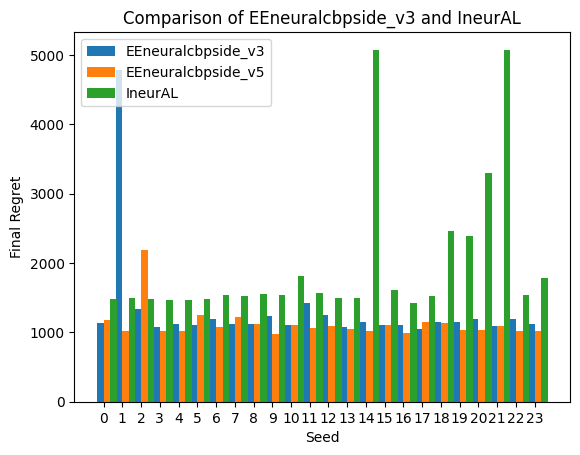

In [6]:
import matplotlib.pyplot as plt
# Creating a barchart

n_folds = 25
horizon = 9999
context = 'MNISTbinary'
case = 'case1'

material = { 
            # 'EEneuralcbpside_v2':{'color':[255,0,0],'label': 'EEneuralcbpside_v2'},
             'EEneuralcbpside_v3':{'color':[0,255,0],'label': 'EEneuralcbpside_v3'},
             'EEneuralcbpside_v5': {'color': [0, 255, 255], 'label': 'EEneuralcbpside_v5'},
            #  'EEneuralcbpside_v4':{'color':[255,255,0],'label': 'EEneuralcbpside_v4'},
            #  'margin':{'color':[255,128,0],'label': 'Margin'},
            #  'cesa':{'color':[0,255,250],'label': 'Cesa'},
             'ineural':{'color':[0,0,255],'label':'IneurAL'},
            'neuronal':{'color':[255,0,255],'label':'neuronal'}  }

final_regrets = {}

# Collect final regrets
for agent_name in material.keys():
    color, l_label = material[agent_name]['color'], material[agent_name]['label']
    direct = './results/'
    path = os.path.join(direct, '{}_{}_{}_{}_{}.pkl.gz'.format(case, context, horizon, n_folds, agent_name))
    result = loadall_results2(path, n_folds)
    result = result[1:]
    result = result.astype(np.float32)

    # Store the final regret of each realization
    final_regrets[l_label] = result[:, -1]



bar_width = 0.35
index = np.arange(len(final_regrets['EEneuralcbpside_v3']))

fig, ax = plt.subplots()
bar1 = ax.bar(index, final_regrets['EEneuralcbpside_v3'], bar_width, label='EEneuralcbpside_v3')
bar2 = ax.bar(index + bar_width, final_regrets['EEneuralcbpside_v5'], bar_width, label='EEneuralcbpside_v5')
bar3 = ax.bar(index + 2* bar_width, final_regrets['IneurAL'], bar_width, label='IneurAL')

ax.set_xlabel('Seed')
ax.set_ylabel('Final Regret')
ax.set_title('Comparison of EEneuralcbpside_v3 and IneurAL')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([str(i) for i in range(len(final_regrets['EEneuralcbpside_v3']))])
ax.legend()

# plt.show()
# plt.savefig('./figures/{}_barchart.pdf'.format(case), dpi=380, bbox_inches='tight')

array([[None, None, None, ..., None, None, None]], dtype=object)